<a href="https://colab.research.google.com/github/siarasmall/comp_phys_proj2/blob/main/Method2Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import numpy as np
from scipy.sparse import diags
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Non-class version to test

In [88]:
NUM_POINTS=500
FRAMES=300
START = 0
END = 100
x, dx = np.linspace(START, END, NUM_POINTS, retstep=True)
dt = 100

In [124]:
M = diags([np.ones(NUM_POINTS-1),-2*np.ones(NUM_POINTS),np.ones(NUM_POINTS-1)], [-1,0,1]).toarray()
# This makes the wavefunction loop around
# M = [[-2. 1. 0. .... 1.]
#      [1. -2. 1. .... 0.]
#      [0. 1. -2. .... 0.]
#      [1. 0. .... 1. -2.]]

M[0][-1]=1
M[-1][0]=1
print(M)

# POTENTIAL
# Zero potential / potential step
# V = np.zeros([NUM_POINTS, NUM_POINTS])
# V[len(V)//2][len(V)//2] = 0.02

# Harmonic potential
pot_val = 0.5 * (0.01*0.01) * (x-x[int(len(x)//2)])**2
V = np.diag(pot_val)


H = -0.5 * (dx*dx) * M + V
I = np.identity(NUM_POINTS)
h1 = I - (1j * dt * 0.5 * H)
h2 = I + (1j * dt * 0.5 * H)
h2_inv = np.linalg.inv(h2)
h_mat = np.matmul(h2_inv, h1)

[[-2.  1.  0. ...  0.  0.  1.]
 [ 1. -2.  1. ...  0.  0.  0.]
 [ 0.  1. -2. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -2.  1.  0.]
 [ 0.  0.  0. ...  1. -2.  1.]
 [ 1.  0.  0. ...  0.  1. -2.]]


In [112]:
def step(psi):
  return np.matmul(h_mat, psi)

In [113]:
def init_gaussian(x, mu, sigma, k):
  A = (2*np.pi)**-0.25 * sigma**-0.5 * np.exp(-(x-mu)**2/((2*sigma)**2))
  return A * np.exp(1j*k*x)

In [122]:
wavefunctions = [init_gaussian(x, 50, 2, 3)]
for i in range(FRAMES):
  wavefunctions.append(step(wavefunctions[-1]))

wavefunctions = np.array(wavefunctions)

# Simulation Class

In [32]:
class WaveFunctionSimulation:
  def __init__(self, start=0, end=100, points=500, dt=100, steps=300, periodic=True, potential=None):
    self.START=start
    self.END=end
    self.NUM_POINTS=points
    self.STEPS=steps
    self.dt=dt
    self.x, self.dx = np.linspace(start, end, points, retstep=True)
    self.periodic=periodic
    self.wavefunctions = []
    # self.initial_psi = np.zeros([self.NUM_POINTS])

    if potential==None:
      self.potential = np.zeros([self.NUM_POINTS])
    else:
      self.potential = potential

    self.step_matrix = self.init_matrix()

  def init_matrix(self):
    M = diags([np.ones(self.NUM_POINTS-1),-2*np.ones(self.NUM_POINTS),np.ones(self.NUM_POINTS-1)], [-1,0,1]).toarray()
    if self.periodic:
      M[0][-1]=1
      M[-1][0]=1

    H = -0.5 * (self.dx*self.dx) * M + self.potential
    I = np.identity(self.NUM_POINTS)
    h1 = I - (1j * self.dt * 0.5 * H)
    h2 = I + (1j * self.dt * 0.5 * H)
    h2_inv = np.linalg.inv(h2)
    return np.matmul(h2_inv, h1)

  def init_gaussian(self, x, mu, sigma, k):
    A = (2*np.pi)**-0.25 * sigma**-0.5 * np.exp(-(x-mu)**2/((2*sigma)**2))
    return A * np.exp(1j*k*x)

  def step(self, psi):
    return np.matmul(self.step_matrix, psi)

  def simulate(self, mu, sigma, k):
    self.wavefunctions = [self.init_gaussian(self.x, mu, sigma, k)]
    for i in range(self.STEPS):
      self.wavefunctions.append(self.step(self.wavefunctions[-1]))

    self.wavefunctions = np.array(self.wavefunctions)
    return self.wavefunctions

  def get_animation_vars(self):
    return self.x, self.START, self.END, self.STEPS

In [33]:
simulation = WaveFunctionSimulation()
wavefunctions = simulation.simulate(50, 2, 3)
x, START, END, FRAMES = simulation.get_animation_vars()

# Basic Animation of Simulation

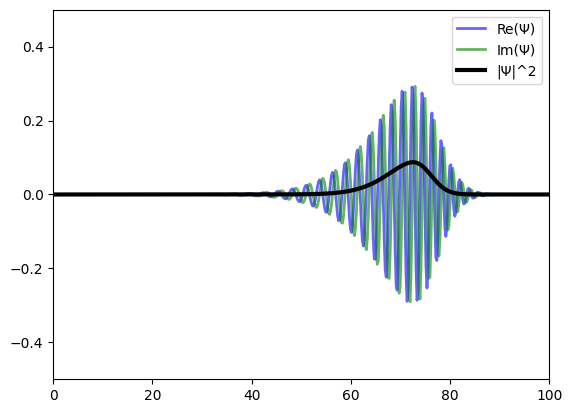

In [34]:
fig = plt.figure()
axis = plt.axes(xlim =(START, END),
                ylim =(-0.5, 0.5))

# initializing a line variable
line1, = axis.plot([], [], 'b', lw = 2, alpha=0.6)
line2, = axis.plot([], [], 'g', lw = 2, alpha=0.6)
line3, = axis.plot([], [], 'k', lw = 3)

# psi = init_gaussian(x, 10, 2, 1)

axis.legend([line1, line2, line3], ['Re(Ψ)', 'Im(Ψ)', '|Ψ|^2'])

def init():
    line1.set_data([], [])
    line2.set_data([], [])
    line3.set_data([], [])
    return line1, line2, line3

def animate(i):
  global psi

  real = wavefunctions[i].real
  imag = wavefunctions[i].imag
  pdf = real**2 + imag**2

  line1.set_data(x, real)
  line2.set_data(x, imag)
  line3.set_data(x, pdf)

  return line1, line2, line3,

anim = FuncAnimation(fig, animate, init_func = init, frames = FRAMES+1, interval = 1, blit = True)

anim.save('test.mp4', writer = 'ffmpeg', fps = 60)